In [1]:
import os
import sys
import pickle
# import torch.multiprocessing as mp
# from functools import partial

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import torch.utils.data as data
import torchvision.models as models
from PIL import Image
from compressai.models import ScaleHyperprior
from compressai.zoo import bmshj2018_hyperprior
from torch import optim, nn, utils
from torchvision import transforms
from torchmetrics import Accuracy

import wandb
from pytorch_lightning.loggers import WandbLogger

# mp.set_start_method('spawn', force=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE=32


In [16]:
class Resnet50(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # init a pretrained resnet
        backbone = models.resnet50(weights="DEFAULT")
        layers = nn.ModuleList(list(backbone.children())[:-1])

        
        self.feature_extractor = nn.Sequential(*layers)

        num_target_classes = 23
        # self.classifier = nn.Linear(128*2048, 23)
        self.classifier = nn.Linear(2048, 23)
        
        
        
        self.training_targets = []
        self.validation_targets = []
        
        self.training_predictions = []
        self.validation_predictions = []
        
        self.training_step_losses = []
        self.validation_step_losses = []
        
        self.top1_accuracy = Accuracy(task="multiclass", num_classes=num_target_classes)
        self.top5_accuracy = Accuracy(task="multiclass", num_classes=num_target_classes, top_k=5)
        
        # save hyper-parameters to self.hparamsm auto-logged by wandb
        self.save_hyperparameters()
        

    def make_layer(self, block, out_channels, blocks, stride=1):

        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv1x1(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = nn.ModuleList()
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        # print(*layers)
        return nn.Sequential(*layers)

    def forward(self, x):
        print(x.shape)
        representations = self.feature_extractor(x)

        representations = representations.view(representations.size(0), -1)
        
        output = self.classifier(representations)
        return output

    def training_step(self, batch, batch_idx):
        x, x_hat, target = batch
        target = target.to(device)

      
        predict = self.forward(x_hat)
        batch_loss = F.cross_entropy(predict, target)
        
        self.training_step_losses.append(batch_loss)

        self.training_targets.append(target)
        self.training_predictions.append(predict)
        
        return batch_loss
    
    def validation_step(self, batch, batch_idx):
        x, x_hat, target = batch
        
        target = target.to(device)

        
      
        with torch.no_grad():
            predict = self.forward(x_hat)
            batch_loss = F.cross_entropy(predict, target)
            
        self.validation_step_losses.append(batch_loss)

            
        self.validation_targets.append(target)
        self.validation_predictions.append(predict)
        
        return batch_loss
    
    def on_train_epoch_end(self):
        # print(torch.cat(self.training_targets).shape)
        # print(torch.cat(self.training_predictions).shape)
        
        loss = F.cross_entropy(torch.cat(self.training_predictions), torch.cat(self.training_targets))
        # loss1 = sum(self.training_step_losses) / len(self.training_step_losses)
        top1_accuracy = self.top1_accuracy(torch.cat(self.training_predictions), torch.cat(self.training_targets)) 
        top5_accuracy = self.top5_accuracy(torch.cat(self.training_predictions), torch.cat(self.training_targets)) 
        print("\nTrain loss:", loss)
        print("Train top-1 acc:", top1_accuracy)
        print("Train top-5 acc:", top5_accuracy)
        self.log("train loss", loss)
        self.log("train top-1 acc", top1_accuracy)
        self.log("train top-5 acc", top5_accuracy)
        self.training_targets.clear()
        self.training_predictions.clear()
        self.training_step_losses.clear()
        
    def on_validation_epoch_end(self):
        print(torch.cat(self.validation_targets).shape)
        print(torch.cat(self.validation_predictions).shape)
        
        loss = F.cross_entropy(torch.cat(self.validation_predictions), torch.cat(self.validation_targets))
        top1_accuracy = self.top1_accuracy(torch.cat(self.validation_predictions), torch.cat(self.validation_targets)) 
        top5_accuracy = self.top5_accuracy(torch.cat(self.validation_predictions), torch.cat(self.validation_targets)) 
        # loss = sum(self.validation_step_losses) / len(self.validation_step_losses)
        
        print("\nVal loss:", loss)
        print("Val top-1 acc:", top1_accuracy)
        print("Val top-5 acc:", top5_accuracy)
        self.log("val loss", loss)
        self.log("val top-1 acc", top1_accuracy)
        self.log("val top-5 acc", top5_accuracy)
        self.validation_targets.clear()
        self.validation_predictions.clear()
        self.validation_step_losses.clear()
    

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [{"scheduler": scheduler, "interval": "epoch"}]
        
        # return optimizer

In [3]:
def compute_psnr(a, b):
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

def compute_msssim(a, b):
    return ms_ssim(a, b, data_range=1.).item()

def compute_bpp(out_net):
    size = out_net['x_hat'].size()
    num_pixels = size[0] * size[2] * size[3]
    return sum(torch.log(likelihoods).sum() / (-math.log(2) * num_pixels)
              for likelihoods in out_net['likelihoods'].values()).item()

In [21]:
# We use the train-validation-test split
# 1 provided in the dataset, with 2125 training images, 125
# validation images and 250 testing images for each class.

class MINCDatasetDecoded(data.Dataset):
    NUM_CLASS = 23

    def __init__(self, root=os.path.expanduser('../'),
                 train=True, quality=1):
        split = 'train' if train == True else 'val'
        root = os.path.join(root, 'minc-mini')
        print(root)
        
        self.classes, self.class_to_idx = find_classes(root + '/images')
        if split == 'train':
            filename = os.path.join(root, 'labels/train1.txt') # 2125
        else:
            filename = os.path.join(root, 'labels/validate1.txt') # 125

        self.images, self.crs, self.labels = make_dataset(filename, root, self.class_to_idx, quality)
        
        self.compression_model = bmshj2018_hyperprior(quality=quality, pretrained=True).eval().to(device)

        assert (len(self.images) == len(self.labels))

    def __getitem__(self, index):
        _image = self.images[index]
        _img = Image.open(_image).convert('RGB')
        _label = self.labels[index]
        
        _img = transforms.ToTensor()(_img)
        _img = transforms.Resize(384)(_img)
    
        _img = _img.unsqueeze(0).to(device)
        
        _compressed_rep = self.crs[index]

        with open(_compressed_rep, 'rb') as handle:
            compressed_rep = pickle.load(handle)
        
        
        with torch.no_grad():
            _x_hat = self.compression_model.decompress(compressed_rep['strings'], compressed_rep['shape'])['x_hat']
            
        # print(_x_hat.shape)
        
        _x_hat = torch.squeeze(_x_hat, 0).to(device)
        _x_hat = transforms.Resize(256)(_x_hat)
        _x_hat = transforms.RandomCrop(224)(_x_hat)
        
        _x_hat = transforms.RandomHorizontalFlip()(_x_hat)
        

        return _image, _x_hat, _label

    def __len__(self):
        return len(self.images)


def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def make_dataset(filename, datadir, class_to_idx, quality):
    images = []
    labels = []
    crs = []
    
    i = 0
    with open(os.path.join(filename), "r") as lines:
        for line in lines:
            _image = os.path.join(datadir, line.rstrip('\n'))
            _dirname = os.path.split(os.path.dirname(_image))[1]
            _compressed_rep = os.path.join(datadir, 'compressed_rep', f'bpp{quality}', _dirname, os.path.splitext(os.path.split(_image)[1])[0])
            assert os.path.isfile(_image)
            assert os.path.isfile(_compressed_rep)
            label = class_to_idx[_dirname]
            images.append(_image)
            crs.append(_compressed_rep)
            labels.append(label)
            
            i += 1
            if i % 1000 == 0: sys.stdout.write('\r'+str(i)+' items loaded')
            
    sys.stdout.write('\r'+str(i)+' items loaded')
                           
              
    return images, crs, labels

In [18]:
train_minc = MINCDataset(train=True,quality=1)
# val_minc = MINCDataset(train=False,quality=1)

../minc-mini
25 items loaded

In [19]:
train_loader = utils.data.DataLoader(train_minc, batch_size=32, shuffle=True)
valdn_loader = utils.data.DataLoader(train_minc, batch_size=32)

In [22]:
wandb_logger = WandbLogger(project='696ds-learning-based-image-compression', log_model=True)

downstream_model = Resnet50()
downstream_model = downstream_model.to(device)
# trainer = pl.Trainer(fast_dev_run = True, logger=wandb_logger)
# print(0.001*48875 , 0.015*2875)
trainer = pl.Trainer(max_epochs=30, logger=wandb_logger)
trainer.fit(model=downstream_model, train_dataloaders=train_loader, val_dataloaders=valdn_loader)
# wandb.finish()

/home/kfaria_umass_edu/.conda/envs/ds696-project/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/kfaria_umass_edu/.conda/envs/ds696-project/lib ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name              | Type               | Params
---------------------------------------------------------
0 | feature_extractor | Sequential         | 23.5 M
1 | classifier        | Linear             | 47.1 K
2 | top1_accuracy     | MulticlassAccuracy | 0     
3 | top5_accuracy     | MulticlassAccuracy | 0     
---------------------------------------------------------
23.6 M    Trainable param

Sanity Checking: 0it [00:00, ?it/s]

/home/kfaria_umass_edu/.conda/envs/ds696-project/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/kfaria_umass_edu/.conda/envs/ds696-project/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still

torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 82.18it/s]torch.Size([25])
torch.Size([25, 23])

Val loss: tensor(3.1346, device='cuda:0')
Val top-1 acc: tensor(0., device='cuda:0')
Val top-5 acc: tensor(0.1200, device='cuda:0')
                             

/home/kfaria_umass_edu/.conda/envs/ds696-project/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/kfaria_umass_edu/.conda/envs/ds696-project/lib/python3.9/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([25, 3, 224, 224])
Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s, v_num=7cs3]
Validation: 0it [00:00, ?it/s]torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1,

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1/1 [00:04<00:00,  4.38s/it, v_num=7cs3]


In [ ]:
# checkpoint_reference = "umass-iesl-is/696ds-learning-based-image-compression/model-sh08q7s9:v0"

# # download checkpoint locally (if not already cached)
# run = wandb.init(project='696ds-learning-based-image-compression')
# artifact = run.use_artifact(checkpoint_reference, type="model")
# artifact_dir = artifact.download()

# # load checkpoint
# downstream_model = cResnet39.load_from_checkpoint(os.path.join(artifact_dir,"model.ckpt"))

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([25, 3, 224, 224])
top 1: 1.0
top 5: 1.0
loss : 0.6273583769798279
Label 4
Label 4
Label 4
Label 1
Label 3
Label 4
Label 2
Label 1
Label 0
Label 0
Label 0
Label 3
Label 3
Label 2
Label 0
Label 1
Label 3
Label 1
Label 2
Label 0
Label 2


/scratch/gypsum-gpu055/6819722/ipykernel_50794/1842647458.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f, axarr = plt.subplots(1,3)


Label 2
Label 1
Label 3
Label 4


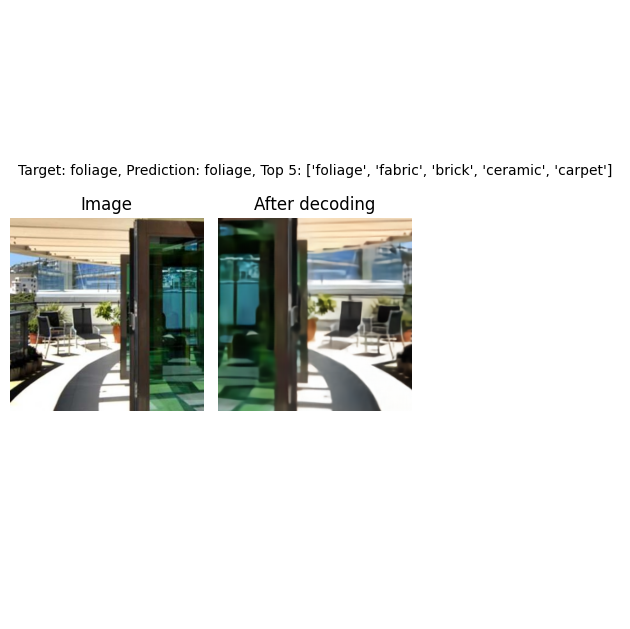

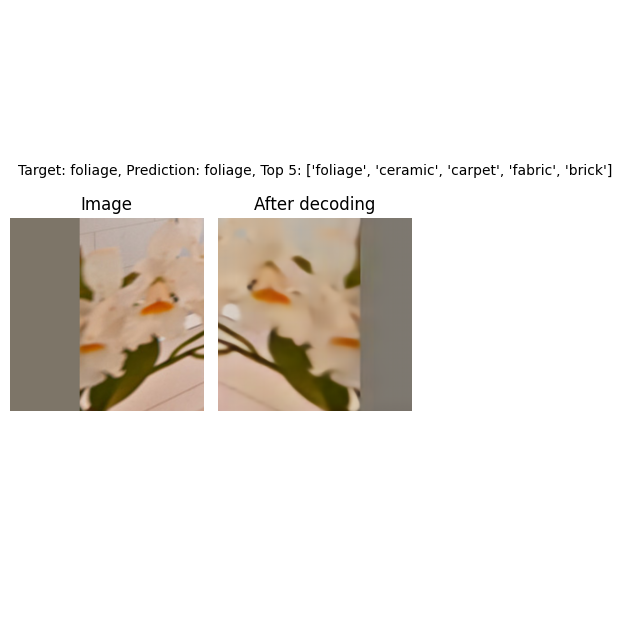

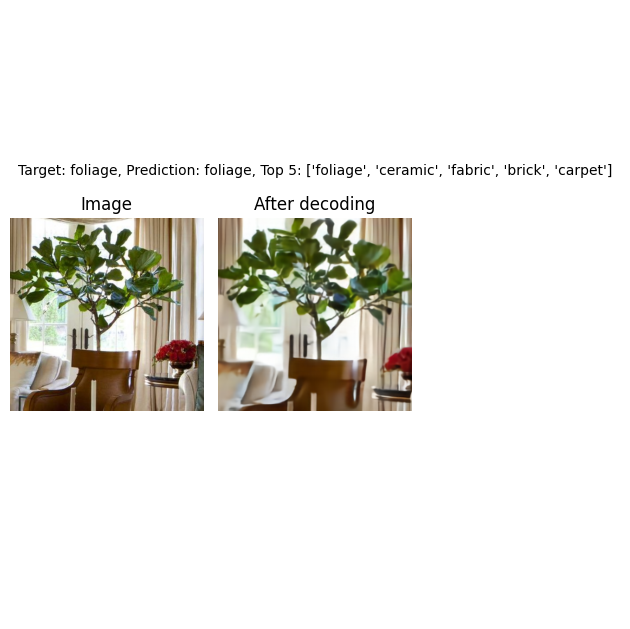

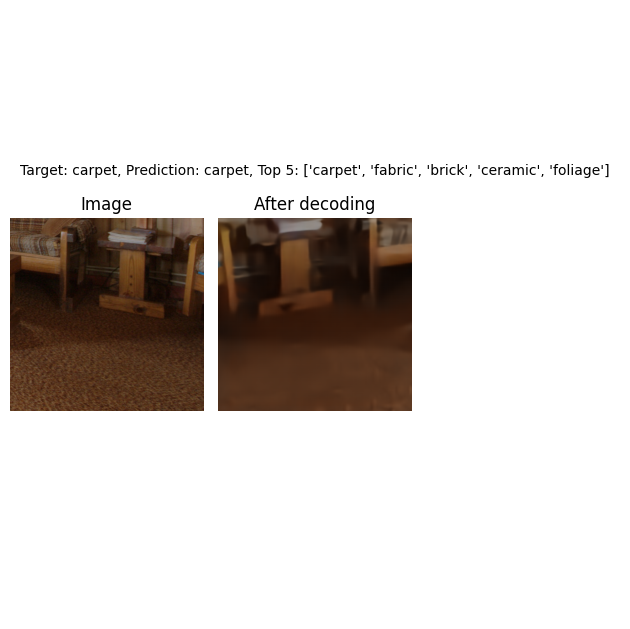

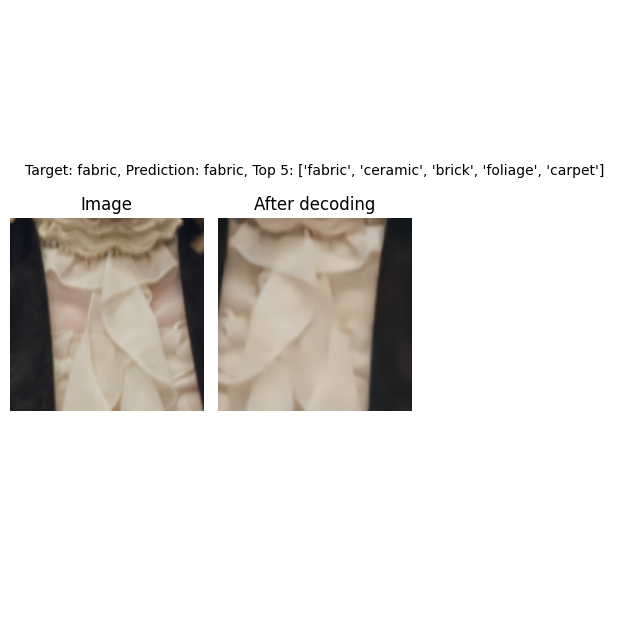

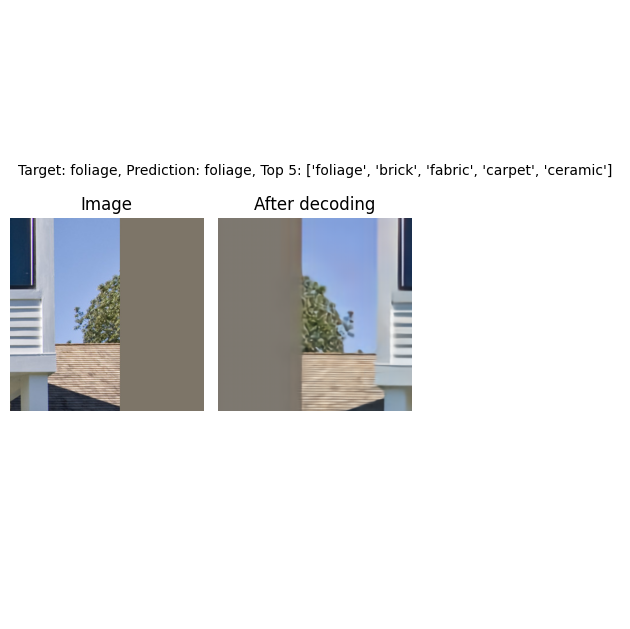

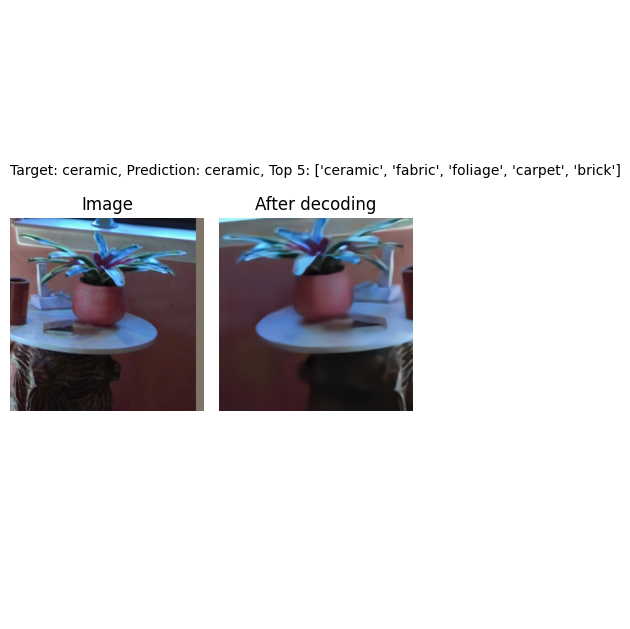

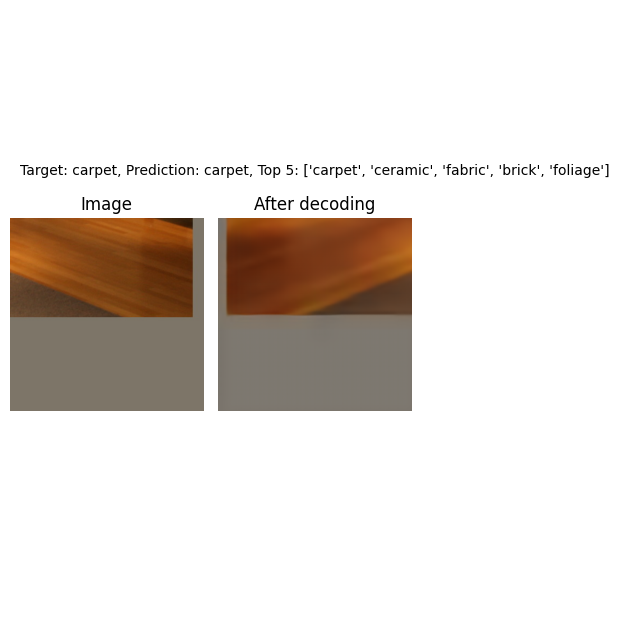

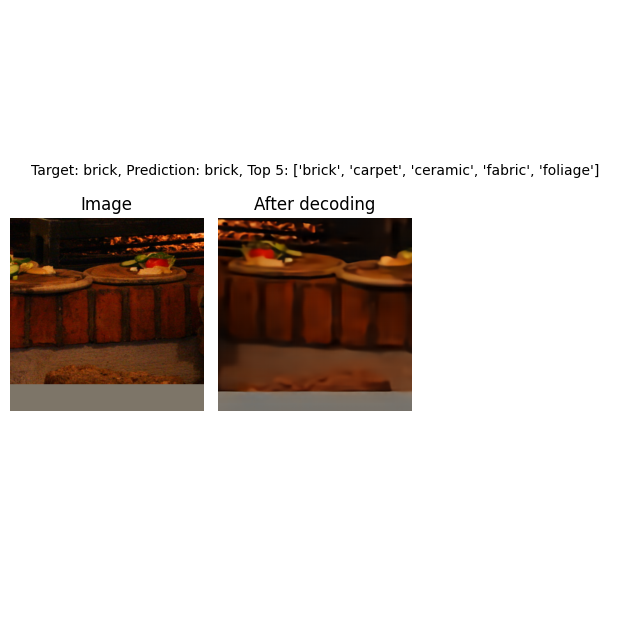

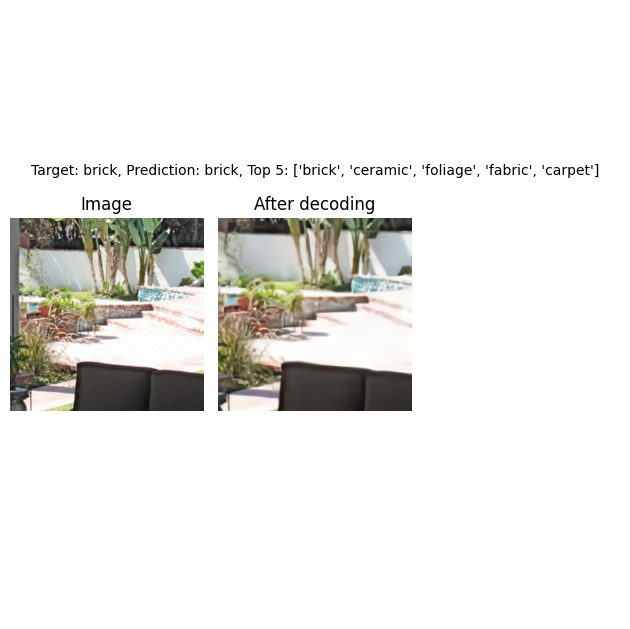

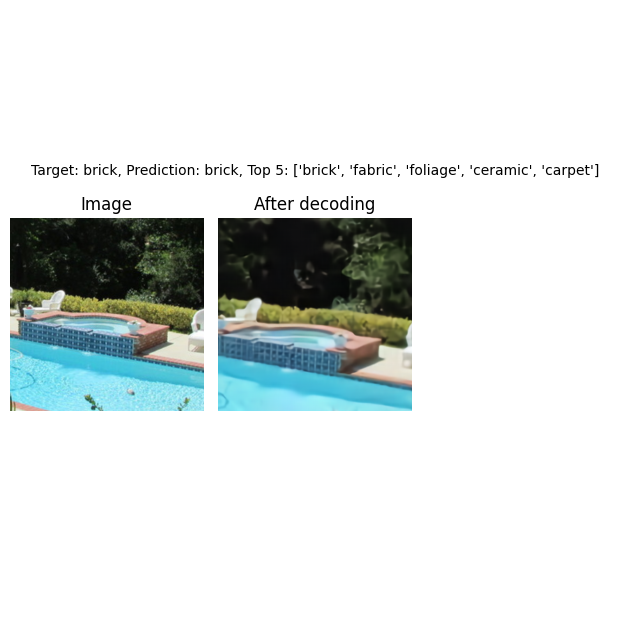

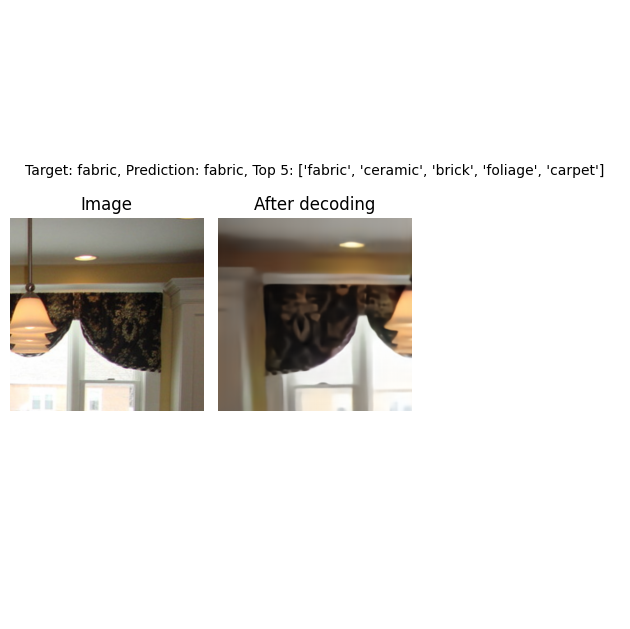

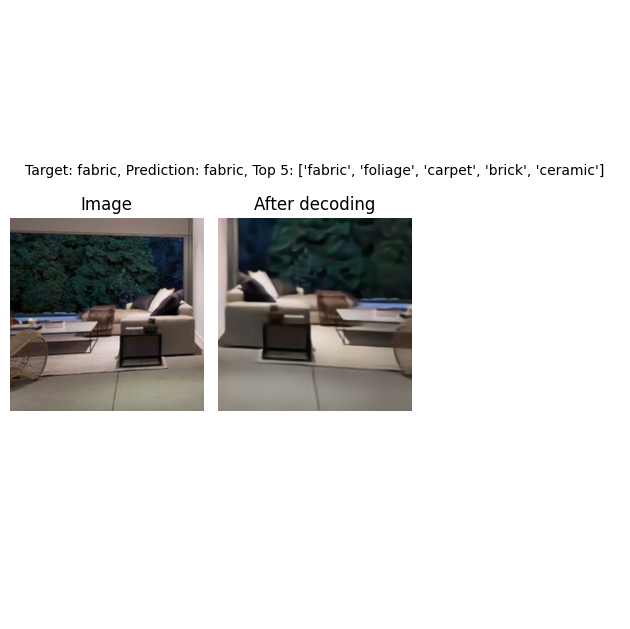

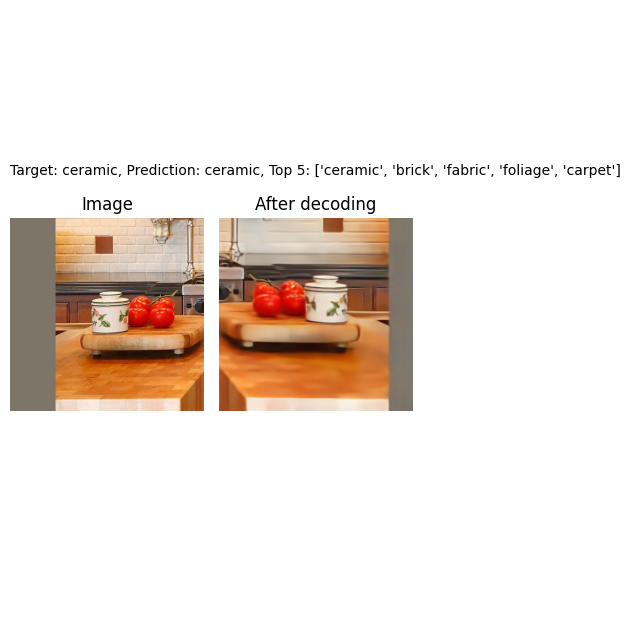

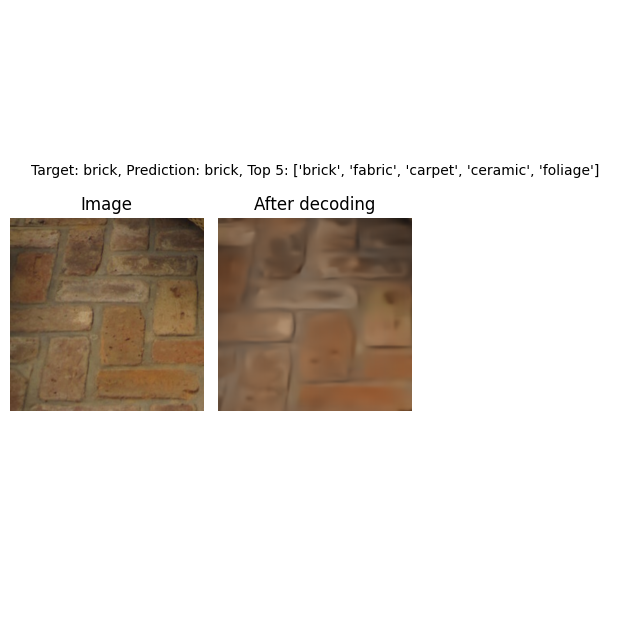

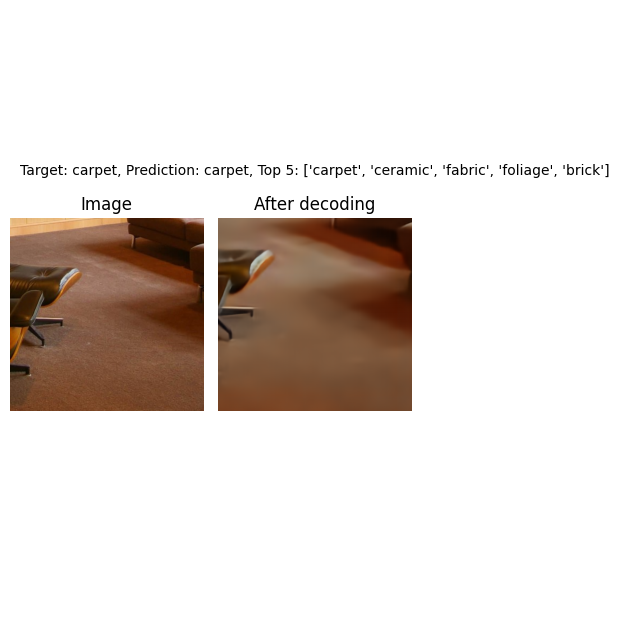

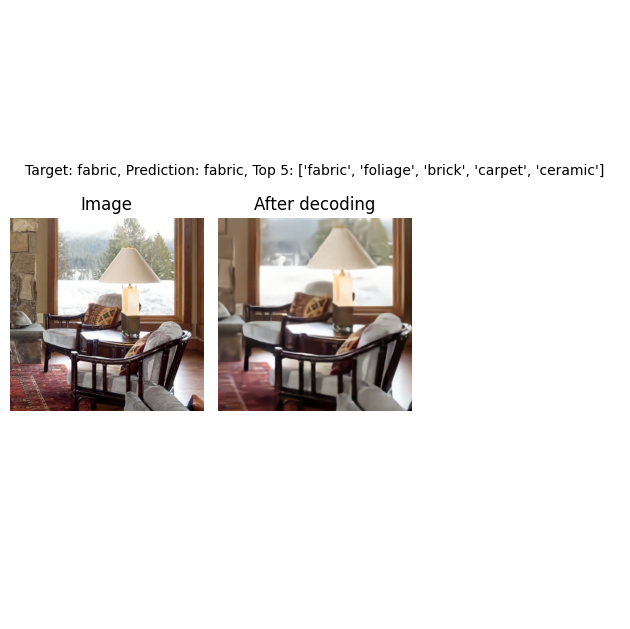

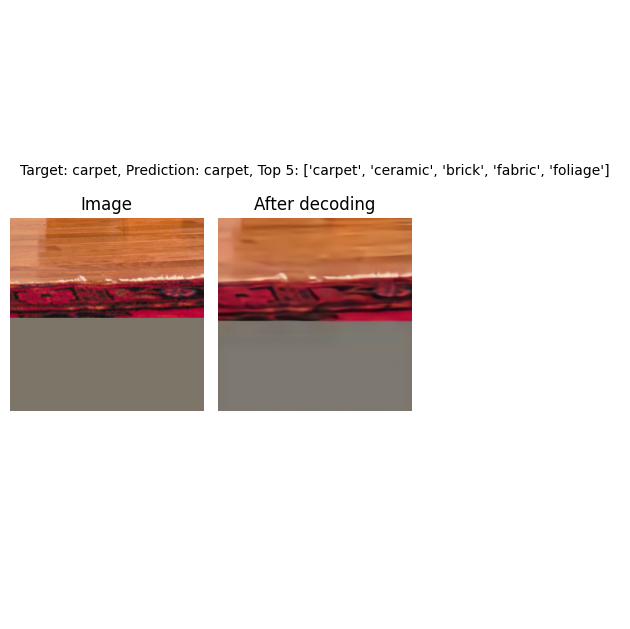

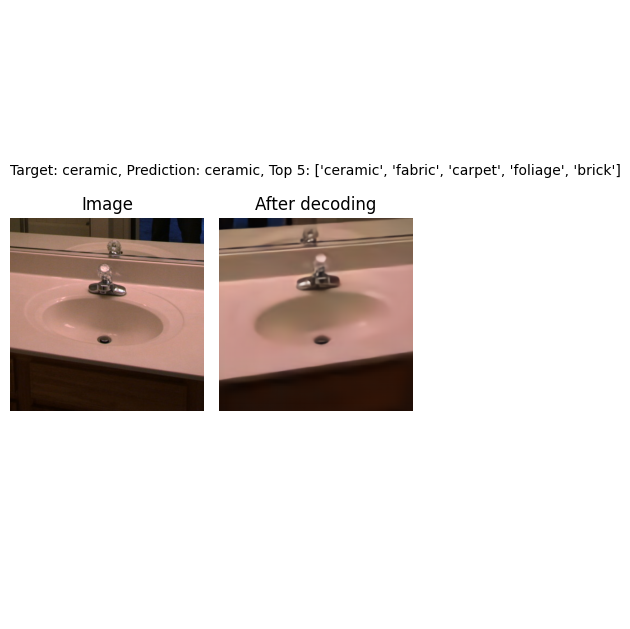

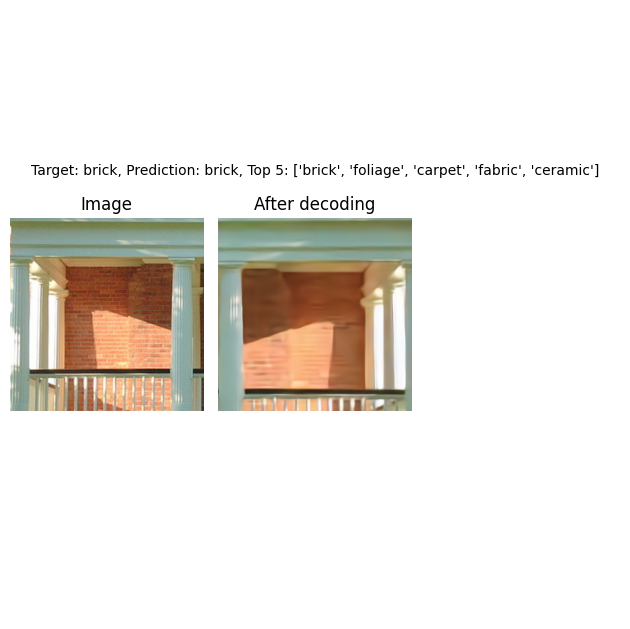

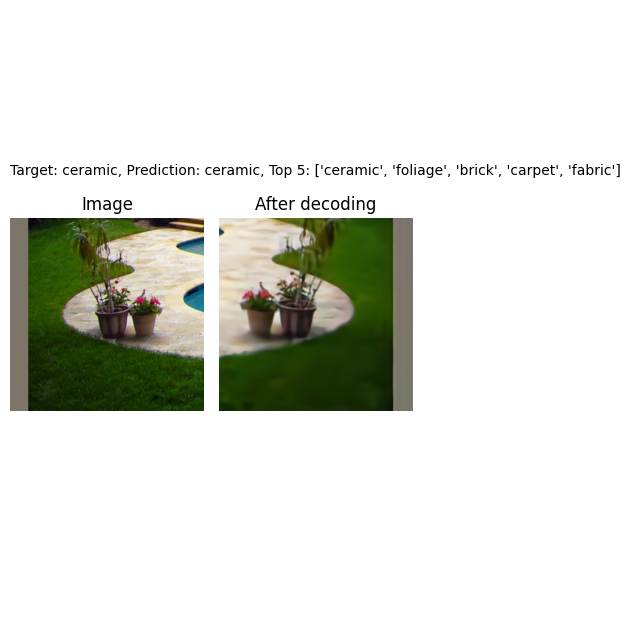

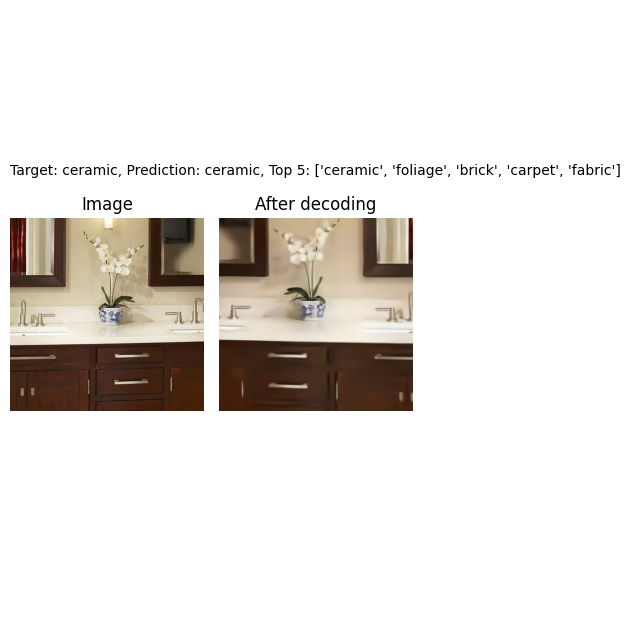

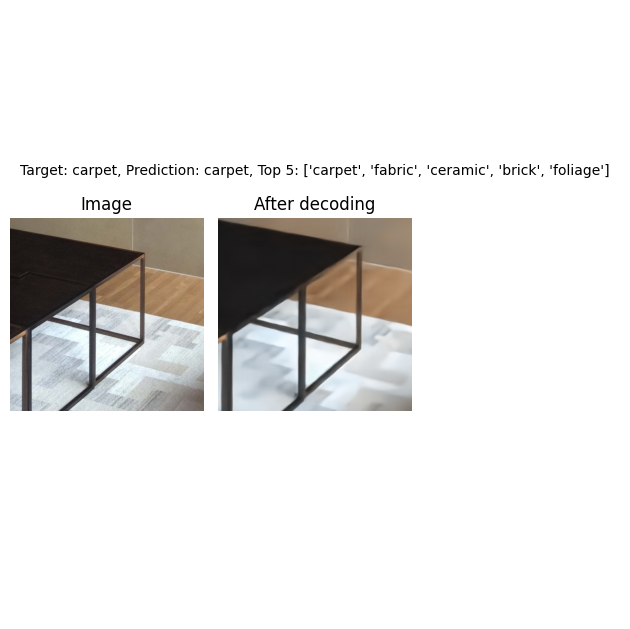

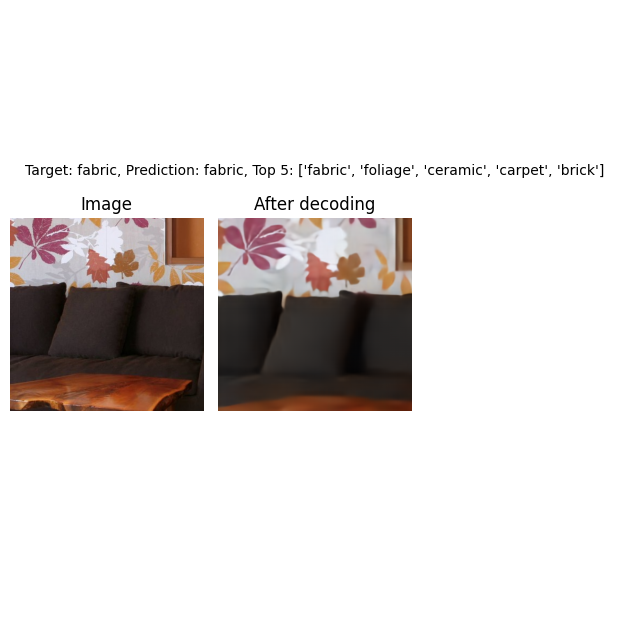

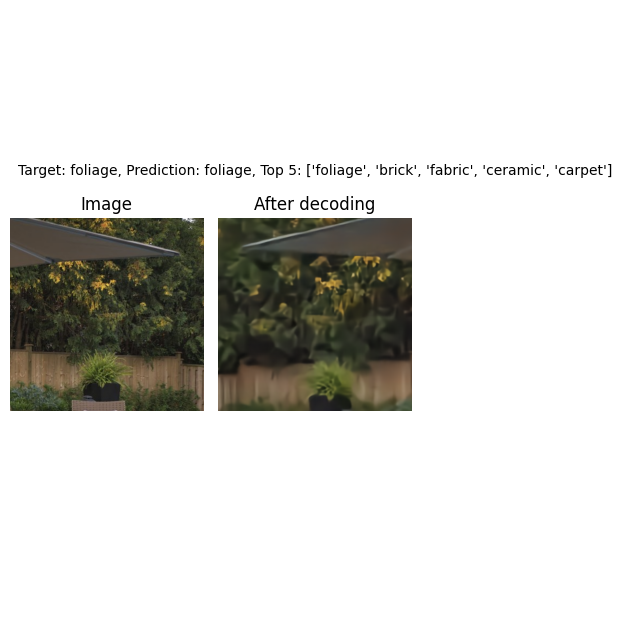

In [28]:
downstream_model.to(device).eval()

with torch.no_grad():
    for batch_idx, batch in enumerate(train_loader):
        x, x_hat, target = batch
        
        target = target.to(device)


        predict = downstream_model(x_hat)
        loss = F.cross_entropy(predict, target)
        print("top 1:", Accuracy(task="multiclass", num_classes=23).to(device)(predict, target).item())
        print("top 5:", Accuracy(task="multiclass", num_classes=23, top_k=5).to(device)(predict, target).item())
        print("loss :", loss.item())
        
        for idx, img in enumerate(x):
            print("Label", target[idx].item())
            
            img = Image.open(img).convert('RGB')
            
            f, axarr = plt.subplots(1,3)
            axarr[0].axis('off')
            axarr[1].axis('off')
            axarr[2].axis('off')
            
            axarr[0].imshow(img)
            axarr[0].title.set_text('Image')
            
            axarr[1].imshow(x_hat[idx].cpu().permute(1, 2, 0))
            axarr[1].title.set_text('After decoding')
            
            
            f.suptitle(f'Target: {train_minc.classes[target[idx].item()]}, Prediction: {train_minc.classes[torch.argmax(predict[idx])]}, Top 5: {[train_minc.classes[p] for p in torch.topk(predict[idx], 5).indices.tolist()]}', fontsize=10)
            f.tight_layout()
            f.subplots_adjust(top=1.3)
            
            
wandb.finish()